# model

Please refer to README file for project overview.

In [1]:
data_dir = "../../../DATA/behavioral_cloning_data/"
processed_images_dir = "processed_images_224x224/"

In [2]:

import matplotlib.image as mpimg
from scipy import misc
import matplotlib.pyplot as plt
import cv2

In [3]:
import DataHelper
#print(DataHelper.__doc__)
from DataHelper import test_read_csv, read_csv
#print(read_csv.__doc__)
#test_read_csv()
# fetch actual log of driving data
headers, data = read_csv(data_dir + "driving_log.csv")

Using TensorFlow backend.


imported rows 8037


# Labels (steering value classes)

- Please review notebook "preprocessing", section: "Steering value distribution".
- Training labels have values ranging from -1 to +1.
- When you steer with **keyboard** the STEPS are rather corse, so I think I can get away with **discrete steering angles, i.e. classes**.
- I will start training with 21 equally spread classes, if needed I will increase to 41.
- I want to make sure that my classes include **0.0 (zero)** as it is most common value.

steering_classes [-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9  1. ]
Number of classes 21


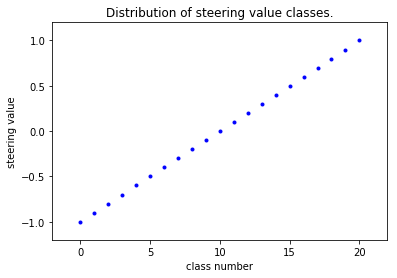

In [4]:
import numpy as np
from numpy import ndarray
number_of_classes = 21
steering_classes = np.linspace(-1, 1, num=number_of_classes, endpoint=True) 
steering_classes = np.sort(steering_classes)
print("steering_classes", steering_classes)
print("Number of classes",steering_classes.shape[0])

import matplotlib.pyplot as plt
plt.plot(steering_classes, 'b.')
plt.margins(0.1)
plt.title("Distribution of steering value classes.")
plt.xlabel("class number")
plt.ylabel('steering value')
plt.show()

# Split data into training, testing and validation sets

In [5]:
from DataHelper import split_random, get_image_center_values
image_center_values = get_image_center_values(data)

training, testing, validation = \
split_random(data, percent_train=5, percent_test=15) 

print("training",training.shape)
print("testing",testing.shape)
print("validation",validation.shape)

percent_validation 80
training (402, 7)
testing (1206, 7)
validation (6428, 7)


# Extract training features (images)

In [6]:
from DataHelper import get_image_center_values 
image_names = get_image_center_values(training)
print(image_names.shape)
print(image_names[1])

(402,)
IMG/center_2016_12_01_13_41_40_922.jpg


## Create a list of image paths pointing to 64px version

In [7]:
image_paths = []
for image_name in image_names:
    image_paths.extend([data_dir + processed_images_dir + image_name])
print(image_paths[1]) 

../../../DATA/behavioral_cloning_data/processed_images_224x224/IMG/center_2016_12_01_13_41_40_922.jpg


matrix shape (402, 224, 224, 3)


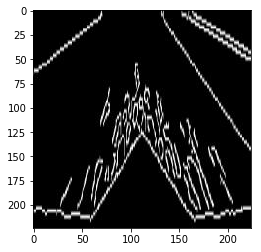

In [8]:
from DataHelper import read_image
training_features = np.array([ read_image(path) for path in image_paths] )

print ("matrix shape", training_features.shape)
plt.imshow(training_features[2], cmap='gray')
plt.show()
#print (training_features[2])

In [9]:
from DataHelper import normalize_grayscale

training_features_normalized = normalize_grayscale(training_features)

# Extract training labels (steering value classes) 

In [10]:
from DataHelper import get_steering_values, find_nearest
raw_labels = get_steering_values(training)
print(raw_labels.shape)
print(raw_labels[0:5])

training_labels = np.array([], dtype=np.float64)

for raw_label in raw_labels: # raw_labels[:5]
    #print("raw_label", raw_label)
    label = find_nearest(steering_classes, raw_label)
    #print("normalized label", label)
    
    # Classification labels should be strings:
    training_labels = np.append(training_labels, [str(label)])
        
print(training_labels)

(402,)
[ 0.         -0.05975719  0.          0.         -0.1452064 ]
['0.0' '-0.1' '0.0' '0.0' '-0.1' '0.0' '0.0' '0.0' '-0.6' '0.0' '0.0' '0.2'
 '-0.3' '0.3' '0.0' '0.1' '-0.1' '0.0' '0.0' '0.0' '0.0' '-0.2' '0.0' '0.0'
 '0.1' '0.3' '0.0' '-0.1' '0.0' '0.0' '0.4' '0.1' '0.0' '0.0' '0.0' '-0.1'
 '0.0' '0.0' '0.0' '0.0' '0.3' '0.0' '0.0' '0.0' '-0.2' '0.0' '0.1' '0.2'
 '0.1' '0.0' '-0.2' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.1'
 '0.0' '-0.3' '-0.2' '0.0' '0.3' '0.0' '0.0' '0.5' '-0.1' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '-0.1' '0.0' '-0.1' '-0.1'
 '0.0' '0.1' '-0.1' '-0.1' '0.0' '0.0' '0.3' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.2' '-0.1' '0.0' '0.0' '0.0' '0.0' '-0.2' '0.0' '-0.3' '0.0' '0.0' '0.0'
 '0.0' '0.0' '-0.2' '0.2' '0.4' '0.1' '0.0' '0.0' '0.0' '0.0' '0.0' '0.3'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.2' '0.0' '-0.1' '0.0' '0.0' '0.2'
 '0.2' '-0.1' '0.0' '-0.4' '-0.1' '-0.2' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.2' '0.2' '0.0' '0.

## One hot

In [11]:
import sklearn
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_one_hot = label_binarizer.fit_transform(training_labels)
print(y_one_hot)

[[0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


# Extract 

# Keras (with TensorFlow)

https://keras.io/layers/convolutional/

In [12]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import ELU
from keras.layers.core import Flatten, Dense, Dropout, Activation, Lambda

from keras.activations import relu, softmax
from keras.optimizers import SGD
import cv2, numpy as np
from DataHelper import mean_pred, false_rates

from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Convolution1D
print("training_features_normalized", training_features_normalized.shape)
print("y_one_hot", y_one_hot.shape)

training_features_normalized (402, 224, 224, 3)
y_one_hot (402, 12)


### See Model_Keras_VGG_16.py

This file (in the same directory) contains MODEL definiteion for VGG.16.

In [13]:
from Model_Keras_VGG_16 import build_model # model = build_model('vgg16_weights.h5')

build_model v5


In [14]:
model = build_model()

ValueError: Negative dimension size caused by subtracting 2 from 1 for 'MaxPool_1' (op: 'MaxPool') with input shapes: [?,112,1,128].

In [ ]:
#    im = cv2.resize(cv2.imread('cat.jpg'), (224, 224)).astype(np.float32)
#    im[:,:,0] -= 103.939
#    im[:,:,1] -= 116.779
#    im[:,:,2] -= 123.68
#    im = im.transpose((2,0,1))
#    im = np.expand_dims(im, axis=0)
#
#    # Test pretrained model
#    model = VGG_16('vgg16_weights.h5')
#   sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
#    model.compile(optimizer=sgd, loss='categorical_crossentropy')
#    out = model.predict(im)
#    print np.argmax(out)

# Before training a model, you need to configure the learning process, which is done via the compile method.
optimizer='sgd' # | 'rmsprop'
loss_function='mean_squared_error' # | 'binary_crossentropy' | 'mse'
metrics_array=['accuracy', mean_pred, false_rates]
model.compile(optimizer, loss_function, metrics_array)

history = model.fit(training_features_normalized, training_labels, nb_epoch=3, verbose=1,validation_split=0.2)
#history = model.fit(training_features_normalized, y_one_hot, nb_epoch=3, validation_split=0.2)

#Epoch 20/20 loss: 0.0518 - acc: 0.60 - val_loss: 0.05 - val_acc: 0.59